# `streamline_races_featurization.ipynb`

### Author: Anthony Hein

#### Last updated: 11/3/2021

# Overview:

Perform feature engineering on the races dataset to provide better input to machine learning models.

---

## Setup

In [1]:
from datetime import datetime
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `horses_selected_trimmed_clean_augmented.csv`

In [3]:
horses_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/horses_selected_trimmed_clean_augmented.csv", low_memory=False) 
horses_clean.head()

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,OR,father,mother,gfather,weight,res_win,res_place,res_show,finishing time,finishing time ratio
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0,277.200000,1.000000
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0,278.679948,1.005339
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,Nordico,Over The Seas,North Summit,71,0,0,0,278.957438,1.006340
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0,284.507242,1.026361
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0,290.057045,1.046382


In [4]:
horses_clean.shape

(202304, 24)

---

## Load `races_selected_trimmed_clean.csv`

In [5]:
races_clean = pd.read_csv(f"{BASE_DIR}/data/streamline/races_selected_trimmed_clean.csv", low_memory=False) 
races_clean.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,station name,station lat,station lng,dist to station,station reading date,temp,msl,rain,rhum,station reading timedelta
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,BIRR,53.0525,-7.5325,45.288813,1/9/97 12:00,1.6,1012.4,0.0,87,15.0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,CASEMENT,53.1820,-6.2620,24.477602,2/16/97 15:00,8.0,992.5,0.4,87,20.0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,SHANNON AIRPORT,52.4125,-8.5505,63.534139,3/1/97 14:00,12.0,1003.5,0.0,73,0.0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,CASEMENT,53.1820,-6.2620,24.477602,4/24/97 14:00,12.6,1011.9,0.0,72,20.0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,SHANNON AIRPORT,52.4125,-8.5505,25.222137,5/8/97 17:00,11.1,994.2,0.0,59,30.0


In [6]:
races_clean.shape

(20201, 34)

In [7]:
races_featurized = races_clean.copy()
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,station name,station lat,station lng,dist to station,station reading date,temp,msl,rain,rhum,station reading timedelta
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,BIRR,53.0525,-7.5325,45.288813,1/9/97 12:00,1.6,1012.4,0.0,87,15.0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,CASEMENT,53.1820,-6.2620,24.477602,2/16/97 15:00,8.0,992.5,0.4,87,20.0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,SHANNON AIRPORT,52.4125,-8.5505,63.534139,3/1/97 14:00,12.0,1003.5,0.0,73,0.0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,CASEMENT,53.1820,-6.2620,24.477602,4/24/97 14:00,12.6,1011.9,0.0,72,20.0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,SHANNON AIRPORT,52.4125,-8.5505,25.222137,5/8/97 17:00,11.1,994.2,0.0,59,30.0


---

## One-Hot Encoding Helper Function

In [8]:
def get_one_hot_encode(variable: str, threshold: float = 0) -> pd.core.frame.DataFrame:
    """
    Group together categorical variables which occur in frequencies lower than `threshold`.
    """
    
    frequencies = races_featurized[variable].value_counts(normalize=True)
    mask = races_featurized[variable].map(frequencies) < threshold
    return races_featurized[variable].mask(mask, 'Other')

In [9]:
get_one_hot_encode('course', 0.01)

0               Other
1         Punchestown
2            Listowel
3         Punchestown
4           Tipperary
             ...     
20196      Down Royal
20197         Clonmel
20198    Leopardstown
20199    Leopardstown
20200    Leopardstown
Name: course, Length: 20201, dtype: object

In [10]:
get_one_hot_encode('course', 0.01).value_counts(normalize=True)

Dundalk         0.178060
Curragh         0.110589
Leopardstown    0.102074
Cork            0.047819
Naas            0.045047
Tipperary       0.043463
Gowran Park     0.043315
Navan           0.034850
Fairyhouse      0.034008
Killarney       0.033662
Galway          0.031682
Down Royal      0.030741
Roscommon       0.029157
Limerick        0.028909
Listowel        0.025048
Tramore         0.023563
Wexford         0.020049
Sligo           0.019504
Other           0.019207
Ballinrobe      0.019157
Tralee          0.018365
Bellewstown     0.017870
Clonmel         0.016237
Punchestown     0.014702
Downpatrick     0.012920
Name: course, dtype: float64

---

## One-Hot Encode `course`

In [11]:
races_featurized['course'].value_counts(normalize=True)

Dundalk         0.178060
Curragh         0.110589
Leopardstown    0.102074
Cork            0.047819
Naas            0.045047
Tipperary       0.043463
Gowran Park     0.043315
Navan           0.034850
Fairyhouse      0.034008
Killarney       0.033662
Galway          0.031682
Down Royal      0.030741
Roscommon       0.029157
Limerick        0.028909
Listowel        0.025048
Tramore         0.023563
Wexford         0.020049
Sligo           0.019504
Ballinrobe      0.019157
Tralee          0.018365
Bellewstown     0.017870
Clonmel         0.016237
Punchestown     0.014702
Downpatrick     0.012920
Thurles         0.008316
Kilbeggan       0.005247
Laytown         0.005148
Mallow          0.000495
Name: course, dtype: float64

In [12]:
races_featurized = races_featurized.join(pd.get_dummies(get_one_hot_encode('course', 0.01), prefix='course_'))
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,course__Naas,course__Navan,course__Other,course__Punchestown,course__Roscommon,course__Sligo,course__Tipperary,course__Tralee,course__Tramore,course__Wexford
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,0,1,0,0,0,0,0,0,0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,0,0,0,1,0,0,0,0,0,0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,0,0,0,0,0,0,0,0,0,0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,0,0,1,0,0,0,0,0,0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,0,0,0,0,0,0,1,0,0,0


---

## One-Hot Encode `metric`

In [13]:
races_featurized['metric'].value_counts(normalize=True)

1407.0    0.152319
1609.0    0.136132
3218.0    0.106430
1206.0    0.090788
2413.0    0.089501
2011.0    0.072769
1005.0    0.070244
2111.5    0.039652
1810.0    0.030048
2815.0    0.028909
1709.5    0.023019
3620.0    0.015643
1910.5    0.014801
3419.0    0.014653
1507.5    0.013910
1306.5    0.013613
2614.0    0.012227
4022.0    0.011138
2212.0    0.010792
3318.5    0.008663
2513.5    0.006782
2312.5    0.006336
3821.0    0.006237
4827.0    0.004158
4424.0    0.002772
1105.5    0.002723
4122.5    0.002624
5028.0    0.001733
3519.5    0.001535
3921.5    0.001436
3016.0    0.001238
4223.0    0.001139
3720.5    0.001040
5128.5    0.000693
5631.0    0.000545
4927.5    0.000495
2714.5    0.000495
4725.5    0.000446
4625.0    0.000446
4323.5    0.000396
3116.5    0.000396
5329.5    0.000248
6637.0    0.000248
4524.5    0.000149
6838.0    0.000149
6436.0    0.000099
5229.0    0.000099
6737.5    0.000050
2915.5    0.000050
Name: metric, dtype: float64

In [14]:
races_featurized = races_featurized.join(pd.get_dummies(get_one_hot_encode('metric', 0.01), prefix='metric_'))
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,metric__2111.5,metric__2212.0,metric__2413.0,metric__2614.0,metric__2815.0,metric__3218.0,metric__3419.0,metric__3620.0,metric__4022.0,metric__Other
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,0,0,0,0,0,0,0,0,1
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,0,0,0,0,0,0,0,0,0,1
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,0,0,0,0,0,0,0,1,0,0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,0,0,0,0,0,0,0,0,1
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,0,0,0,0,0,0,0,0,0,0


---

## One-Hot Encode `ncond`

In [15]:
races_featurized['ncond'].value_counts(normalize=True)

1     0.201228
0     0.176377
2     0.165437
5     0.102272
9     0.079897
6     0.073214
4     0.062076
11    0.056779
12    0.043612
8     0.035790
10    0.003119
17    0.000198
Name: ncond, dtype: float64

In [16]:
races_featurized = races_featurized.join(pd.get_dummies(get_one_hot_encode('ncond', 0.04), prefix='ncond_'))
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,ncond__0,ncond__1,ncond__2,ncond__4,ncond__5,ncond__6,ncond__9,ncond__11,ncond__12,ncond__Other
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,1,0,0,0,0,0,0,0,0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,0,0,0,0,1,0,0,0,0,0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,0,0,0,0,1,0,0,0,0,0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,1,0,0,0,0,0,0,0,0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,0,0,0,1,0,0,0,0,0,0


---

## One-Hot Encode `class`

In [17]:
races_featurized['class'].value_counts(normalize=True)

0    0.999455
1    0.000545
Name: class, dtype: float64

This doesn't make sense to use as a feature.

---

## One-Hot Encode `runners`

In [18]:
races_featurized['runners'].value_counts(normalize=True)

14    0.170487
13    0.106975
10    0.101579
9     0.100441
12    0.097619
8     0.095045
11    0.092966
7     0.085342
6     0.062076
5     0.052324
4     0.025989
3     0.009158
Name: runners, dtype: float64

In [19]:
races_featurized = races_featurized.join(pd.get_dummies(get_one_hot_encode('runners', 0.06), prefix='runners_'))
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,runners__6,runners__7,runners__8,runners__9,runners__10,runners__11,runners__12,runners__13,runners__14,runners__Other
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,1,0,0,0,0,0,0,0,0,0
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,0,0,0,1,0,0,0,0,0,0
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,0,0,1,0,0,0,0,0,0,0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,0,0,0,0,1,0,0,0,0,0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,0,0,0,0,0,0,0,0,0,1


---

## One-Hot Encode `datetime`

To make datetime more digestable as a feature, we will do two things to encode this. First, we will encode the month, which implicitly uses the assumption that weather is similar/constant throughout a month. I feel like this is a fair assumption given how we talk about how cold or warm a _month_ is. Then, we will extract the year and leave it as its own variable. This helps a potential model capture any trends over time. In summary, we propose that anything a model may learn from a datetime is in fact some baseline knowledge about the month of the datetime plus some perturbation introduced by the year. To make this more concrete, this is similar to saying "December is very cold, but gets warmer as the years go on because of global warming."

In [20]:
races_featurized['month'] = races_featurized['datetime'].map(
    lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:00').month
)
races_featurized[['datetime', 'month']].head(10)

,datetime,month
0,1997-01-09 12:15:00,1
1,1997-02-16 14:40:00,2
2,1997-03-01 14:00:00,3
3,1997-04-24 13:40:00,4
4,1997-05-08 17:30:00,5
5,1997-05-11 13:30:00,5
6,1997-05-11 14:00:00,5
7,1997-05-13 13:30:00,5
8,1997-05-13 16:30:00,5
9,1997-05-15 17:30:00,5


In [21]:
races_featurized['month'].value_counts(normalize=True)

8     0.155883
7     0.151824
6     0.138805
5     0.108608
9     0.108361
10    0.087174
4     0.071927
11    0.051631
3     0.040592
12    0.033068
1     0.026880
2     0.025246
Name: month, dtype: float64

In [22]:
races_featurized = races_featurized.join(pd.get_dummies(get_one_hot_encode('month', 0.03), prefix='month_'))
races_featurized.head()

,rid,course,title,winningTime,metric,ncond,class,runners,margin,1st_place_rank_in_odds,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,month__Other
0,302858,Thurles,Liffey Maiden Hurdle (Div 1),277.2,3821.0,1,0,6,1.219263,1,...,0,0,0,0,0,0,0,0,0,1
1,291347,Punchestown,Ericsson G.S.M. Grand National Trial Handicap ...,447.2,5229.0,5,0,9,1.218049,4,...,0,0,0,0,0,0,0,0,0,1
2,75447,Listowel,Ballybunion E.B.F. Beginners S'chase,318.4,3620.0,5,0,8,1.277320,3,...,0,0,0,0,0,0,0,0,0,0
3,358038,Punchestown,Quinns Of Baltinglass Chase (La Touche) (Cross...,533.9,6637.0,1,0,10,1.286595,1,...,1,0,0,0,0,0,0,0,0,0
4,89211,Tipperary,Topaz Sprint Stakes (Listed),59.9,1005.0,4,0,5,1.217043,4,...,0,1,0,0,0,0,0,0,0,0


In [23]:
races_featurized['year'] = races_featurized['datetime'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:00').year)
races_featurized[['datetime', 'year']].sample(10)

,datetime,year
10452,2011-11-11 17:55:00,2011
16092,2017-07-20 17:20:00,2017
9209,2005-06-08 19:30:00,2005
18837,2016-12-07 20:00:00,2016
7822,2007-10-03 14:25:00,2007
3059,2009-07-06 16:40:00,2009
13908,2015-04-06 14:30:00,2015
2547,2019-10-23 12:40:00,2019
17844,2016-03-18 17:30:00,2016
2043,2019-06-18 16:40:00,2019


---

## Bin the Temperature

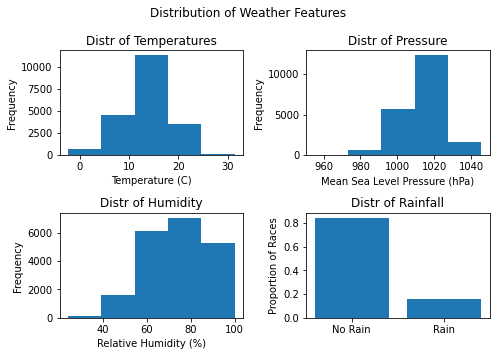

In [38]:
fig = plt.figure(figsize=(7,5))
gs = fig.add_gridspec(2, 2)

fig.suptitle("Distribution of Weather Features")

ax1 = fig.add_subplot(gs[0:1, 0:1])

ax1.set_title("Distr of Temperatures")
ax1.hist(races_featurized['temp'], bins=5)
ax1.set_xlabel("Temperature (C)")
ax1.set_ylabel("Frequency")

ax2 = fig.add_subplot(gs[0:1, 1:2])

ax2.set_title("Distr of Pressure")
ax2.hist(races_featurized['msl'], bins=5)
ax2.set_xlabel("Mean Sea Level Pressure (hPa)")
ax2.set_ylabel("Frequency")

ax3 = fig.add_subplot(gs[1:2, 0:1])

ax3.set_title("Distr of Humidity")
ax3.hist(races_featurized['rhum'], bins=5)
ax3.set_xlabel("Relative Humidity (%)")
ax3.set_ylabel("Frequency")

ax4 = fig.add_subplot(gs[1:2, 1:2])

ax4.set_title("Distr of Rainfall")
ax4.bar(['No Rain', 'Rain'], [1 - np.mean(races_featurized['is_raining']), np.mean(races_featurized['is_raining'])])
ax4.set_ylabel("Proportion of Races")


plt.tight_layout()

fig.savefig(f"{BASE_DIR}/figures/weather_bins.png")

plt.show()

(array([  715.,  4505., 11343.,  3528.,   110.]),
 array([-2.4 ,  4.36, 11.12, 17.88, 24.64, 31.4 ]),
 <BarContainer object of 5 artists>)

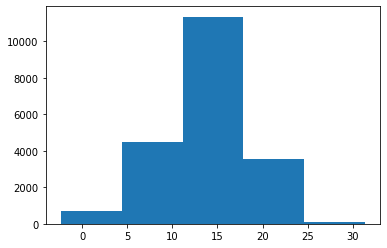

In [25]:
plt.hist(races_featurized['temp'], bins=5)

In [26]:
# cutoffs obtained from the histogram
temp_cutoffs = [-2.4, 4.36, 11.12, 17.88, 24.64, 31.4]

In [27]:
for idx in range(len(temp_cutoffs[:-1])):
    colname = "temp_level_" + str(idx)
    in_bucket = np.logical_and(races_featurized['temp'] > temp_cutoffs[idx],
                               races_featurized['temp'] < temp_cutoffs[idx + 1])
    races_featurized[colname] = [int(elt) for elt in in_bucket]
    
races_featurized[['temp', 'temp_level_0', 'temp_level_1', 'temp_level_2', 'temp_level_3', 'temp_level_4']].head(10)

,temp,temp_level_0,temp_level_1,temp_level_2,temp_level_3,temp_level_4
0,1.6,1,0,0,0,0
1,8.0,0,1,0,0,0
2,12.0,0,0,1,0,0
3,12.6,0,0,1,0,0
4,11.1,0,1,0,0,0
5,6.4,0,1,0,0,0
6,10.0,0,1,0,0,0
7,14.5,0,0,1,0,0
8,13.5,0,0,1,0,0
9,15.4,0,0,1,0,0


---

## Bin the Pressure

(array([   35.,   599.,  5684., 12322.,  1561.]),
 array([ 955.2 ,  973.22,  991.24, 1009.26, 1027.28, 1045.3 ]),
 <BarContainer object of 5 artists>)

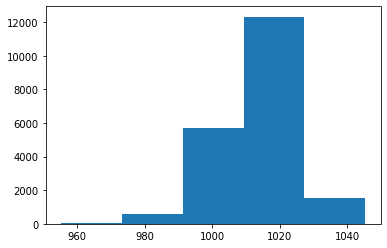

In [28]:
plt.hist(races_featurized['msl'], bins=5)

In [29]:
# cutoffs obtained from the histogram
pressure_cutoffs = [955.2 ,  973.22,  991.24, 1009.26, 1027.28, 1045.3]

In [30]:
for idx in range(len(temp_cutoffs[:-1])):
    colname = 'pressure_level_' + str(idx)
    in_bucket = np.logical_and(races_featurized['msl'] > pressure_cutoffs[idx],
                               races_featurized['msl'] < pressure_cutoffs[idx + 1])
    races_featurized[colname] = [int(elt) for elt in in_bucket]

races_featurized[['msl',
                  'pressure_level_0',
                  'pressure_level_1',
                  'pressure_level_2',
                  'pressure_level_3',
                  'pressure_level_4']].sample(10)

,msl,pressure_level_0,pressure_level_1,pressure_level_2,pressure_level_3,pressure_level_4
3746,1014.8,0,0,0,1,0
4667,1025.0,0,0,0,1,0
18146,1017.0,0,0,0,1,0
3412,1020.5,0,0,0,1,0
7271,996.1,0,0,1,0,0
17864,984.7,0,1,0,0,0
16977,1021.3,0,0,0,1,0
17868,991.2,0,1,0,0,0
8845,1030.1,0,0,0,0,1
7614,1012.0,0,0,0,1,0


---

## Binarize Rain

In [31]:
races_featurized['is_raining'] = [int(elt) for elt in (races_featurized['rain'] > 0)]
races_featurized[['rain', 'is_raining']].sample(20)

,rain,is_raining
17462,0.0,0
203,1.3,1
17430,0.0,0
5570,0.0,0
3819,0.0,0
9259,0.0,0
19167,0.0,0
10397,0.0,0
14493,0.0,0
1877,0.0,0


---

## Bin the Humidity

(array([ 128., 1637., 6139., 7040., 5257.]),
 array([ 24. ,  39.2,  54.4,  69.6,  84.8, 100. ]),
 <BarContainer object of 5 artists>)

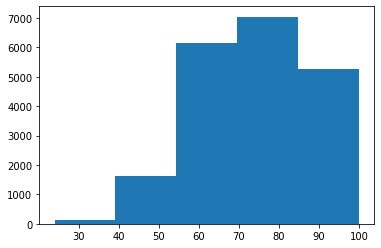

In [32]:
plt.hist(races_featurized['rhum'], bins=5)

In [33]:
# cutoffs obtained from the histogram
humidity_cutoffs = [24., 39.2, 54.4, 69.6, 84.8, 100.]

In [34]:
for idx in range(len(temp_cutoffs[:-1])):
    colname = "rhum_level_" + str(idx)
    in_bucket = np.logical_and(races_featurized['rhum'] > humidity_cutoffs[idx],
                               races_featurized['rhum'] < humidity_cutoffs[idx + 1])
    races_featurized[colname] = [int(elt) for elt in in_bucket]

races_featurized[['rhum', 'rhum_level_0', 'rhum_level_1', 'rhum_level_2', 'rhum_level_3', 'rhum_level_4']].head(10)

,rhum,rhum_level_0,rhum_level_1,rhum_level_2,rhum_level_3,rhum_level_4
0,87,0,0,0,0,1
1,87,0,0,0,0,1
2,73,0,0,0,1,0
3,72,0,0,0,1,0
4,59,0,0,1,0,0
5,94,0,0,0,0,1
6,77,0,0,0,1,0
7,63,0,0,1,0,0
8,65,0,0,1,0,0
9,68,0,0,1,0,0


---

## Add Feature: Entropy of Odds

In [35]:
from scipy.stats import entropy

In [36]:
def entropy_of_odds_for_race(rid: int) -> float:
    """
    Given a race specified by `rid`, calculate the entropy of the distribution
    induced by 
    """
    return entropy(list(horses_clean[horses_clean['rid']==rid]['decimalPrice']))

In [37]:
horses_clean[horses_clean['rid'] == 302858]

,rid,horseName,age,saddle,decimalPrice,isFav,trainerName,jockeyName,position,positionL,...,OR,father,mother,gfather,weight,res_win,res_place,res_show,finishing time,finishing time ratio
0,302858,Kings Return,6.0,4.0,0.600000,1,W P Mullins,D J Casey,1,0,...,NaN,King's Ride,Browne's Return,Deep Run,73,1,1,0,277.200000,1.000000
1,302858,Majestic Red I,6.0,5.0,0.047619,0,John Hackett,Conor O'Dwyer,2,8,...,NaN,Long Pond,Courtlough Lady,Giolla Mear,73,0,1,0,278.679948,1.005339
2,302858,Clearly Canadian,6.0,2.0,0.166667,0,D T Hughes,G Cotter,3,1.5,...,NaN,Nordico,Over The Seas,North Summit,71,0,0,0,278.957438,1.006340
3,302858,Bernestic Wonder,8.0,1.0,0.058824,0,E McNamara,J Old Jones,4,dist,...,NaN,Roselier,Miss Reindeer,Reindeer,73,0,0,0,284.507242,1.026361
4,302858,Beauty's Pride,5.0,6.0,0.038462,0,J J Lennon,T Martin,5,dist,...,NaN,Noalto,Elena's Beauty,Tarqogan,66,0,0,0,290.057045,1.046382
5,302858,Graignamanagh,6.0,3.0,0.307692,0,Harry De Bromhead,J R Barry,40,30,...,NaN,Tremblant,Feathermore,Crash Course,73,0,0,0,295.606849,1.066403


In [38]:
entropy_of_odds_for_race(302858)

1.350363296972622

In [39]:
races_featurized['entropy of odds'] = races_featurized['rid'].map(entropy_of_odds_for_race)

---

## Review

In [41]:
list(races_featurized.columns)

['rid',
 'course',
 'title',
 'winningTime',
 'metric',
 'ncond',
 'class',
 'runners',
 'margin',
 '1st_place_rank_in_odds',
 '2nd_place_rank_in_odds',
 '3rd_place_rank_in_odds',
 '1st_rank_in_odds_place',
 '2nd_rank_in_odds_place',
 '3rd_rank_in_odds_place',
 'placeAvailable',
 'showAvailable',
 'favoriteWon',
 'favoritePlaced',
 'favoriteShowed',
 'lat',
 'lng',
 'datetime',
 'station no',
 'station name',
 'station lat',
 'station lng',
 'dist to station',
 'station reading date',
 'temp',
 'msl',
 'rain',
 'rhum',
 'station reading timedelta',
 'course__Ballinrobe',
 'course__Bellewstown',
 'course__Clonmel',
 'course__Cork',
 'course__Curragh',
 'course__Down Royal',
 'course__Downpatrick',
 'course__Dundalk',
 'course__Fairyhouse',
 'course__Galway',
 'course__Gowran Park',
 'course__Killarney',
 'course__Leopardstown',
 'course__Limerick',
 'course__Listowel',
 'course__Naas',
 'course__Navan',
 'course__Other',
 'course__Punchestown',
 'course__Roscommon',
 'course__Sligo',
 '

---

## Save Dataframe

In [43]:
races_featurized.to_csv(f"{BASE_DIR}/data/streamline/races_featurized.csv", index=False)

---